# AlgoSB 2021

Practical afternoon session Monday, 8th of November. Time-series analysis, covering:

  - Principle component analysis
  - Time-lagged independent analysis
  - Clustering
  - MSM estimation

In [1]:
from dataclasses import dataclass
import sys
import warnings

import cnnclustering
from cnnclustering import cluster
from IPython.core.display import display, HTML
import  matplotlib as mpl
import matplotlib.pyplot as plt
import nglview
import numpy as np
import pyemma
import scipy
from scipy.stats import multivariate_normal
import sklearn
from sklearn import decomposition

Optional dependency module not found:  No module named 'networkx'
Optional dependency module not found:  No module named 'networkx'


In [136]:
# Jupyter display settings
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
# Version information
print("Python: ", *sys.version.split("\n"))

print("Packages:")
for package in [mpl, np, scipy, sklearn, pyemma, nglview, cnnclustering]:
    print(f"    {package.__name__}: {package.__version__}")

Python:  3.8.12 | packaged by conda-forge | (default, Oct 12 2021, 21:57:06)  [GCC 9.4.0]
Packages:
    matplotlib: 3.2.2
    numpy: 1.21.3
    scipy: 1.7.1
    sklearn: 1.0
    pyemma: 2.5.9
    nglview: 3.0.3
    cnnclustering: 0.5.0


In [4]:
# Matplotlib configuration
mpl.rc_file(
    "../matplotlibrc",
    use_default_template=False
)

In [5]:
warnings.simplefilter("ignore")

## Motivation

In [6]:
%%HTML
<video width="90%" src="motivation.mp4" controls></video>

## Outline and organisation

We will demonstrate a few types of analyses that can be used in Markov-model estimation workflows on Molecular Dynamics data. Instead of "real world" MD trajectories, we will use artificial time-series that we produce as follows:

  - We define a **transition-probability matrix** for a number of (conformational) states. An element $ij$ in this matrix denotes the observation probability for a (conformational) transition from state $i$ to state $j$ within a time-step.
  - Starting from this matrix, we generate a possible time-series in state space, i.e. a **discrete trajectory**, which reflects the given transition probabilities.
  - Next, we define our states in terms of underlying **probability distributions** in a **feature space** (e.g. multivariate gaussians).
  - For each time-step in the discrete time-series, we draw a (conformational) sample from the distribution of the  corresponding state to generate a **continuous trajectory**
  - The continuous trajectory (conformational snapshots in the feature space) are subjected to different analyses.

<div class="alert alert-info">

**Note:** In a "real" analysis we would proceed basically the other way round. Starting from a trajectory trough a continuous feature space obtained by a MD simulation, we want to produce a discrete trajectory (e.g. trough clustering) to finally estimate a transition probability matrix that describes our system.
</div>

To organise the "systems" we investigate in this exercise, let's use a simple wrapping object to collect everything a system is made of:

In [8]:
@dataclass
class System:
    desc: str
    transition_p_matrix: np.ndarray = None
    dtraj: np.ndarray = None
    state_distr_map: dict = None
    traj: np.ndarray = None
    pca=None
    tica=None

## Data set generation

In [9]:
system_intro = System("Introductory example")
system = system_intro

### Transition probability matrix and time-series over states

$$
P(\tau) =
\begin{pmatrix}
    p_{00} & ... & p_{02}\\
    \vdots & \ddots & \vdots\\
    p_{20} & ... & p_{22}\\
\end{pmatrix}
= \begin{pmatrix}
    0.98 & 0.00 & 0.02\\
    0.00 & 0.89 & 0.11\\
    0.02 & 0.11 & 0.87\\
\end{pmatrix}
$$

$p_{ij}$: Probability that the system is in state $j$ at time $t + \tau$ after being in state $i$ at time $t$.

In [11]:
# Arbitrary transition probabilities for three states
system.transition_p_matrix = np.array([
    [0.98, 0.00, 0.02],
    [0.00, 0.89, 0.11],
    [0.02, 0.11, 0.87],
])

In [12]:
# Dummy MSM from transition probabilities
sampled_msm = pyemma.msm.SampledMSM(system.transition_p_matrix)
system.dtraj = sampled_msm.simulate(5000)

In [13]:
system.dtraj[:30]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

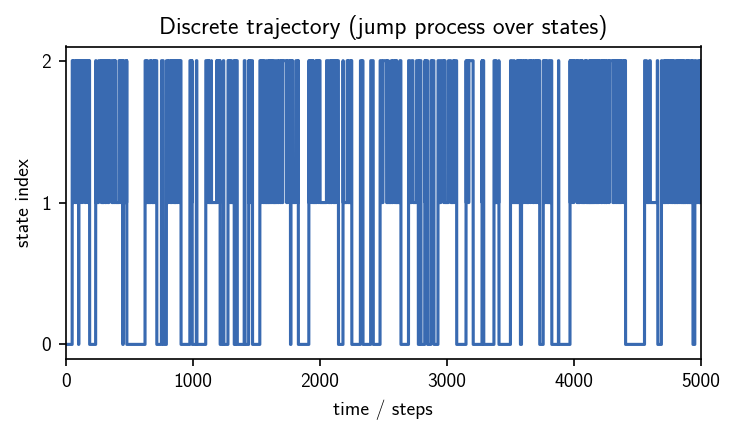

In [22]:
fig, ax = plt.subplots()
line, = ax.plot(system.dtraj)
ax.set(**{
    "title": "Discrete trajectory (jump process over states)",
    "xlabel": "time / steps",
    "ylabel": "state index",
    "xlim": (0, len(system.dtraj)),
    "yticks": np.unique(system.dtraj)
})
fig.tight_layout()

### Probability distributions for states in feature space

Let's assume we know for each state a corresponding probability distribution in a $k$-dimensional conformational space $\mathbb{R}^k$. For example, let's model each state by a multivariate Gaussian with center $\mu$ and covariance matrix $\Sigma$:

$$
f(x) = \frac{1}{\sqrt{(2\pi)^k \det \Sigma}} \exp\left(-\frac{1}{2}(x - \mu)^T \Sigma^{-1} (x - \mu)\right)
$$

In [23]:
# Three states in 2D
state_centers = np.array([
    [-1, 1],
    [1, -1],
    [2, 2],
])
state_covs = np.array([
    [[0.1, 0.0],
     [0.0, 0.3]],
    [[0.4, 0.0],
     [0.0, 0.4]],    
    [[0.2, 0.0],
     [0.0, 0.2]],
])

In [24]:
def make_state_distributions(centers, covs):
    """Create a mapping of state IDs to gaussian distributions"""

    return {
        index: multivariate_normal(mean=center, cov=cov)
        for index, (center, cov) in enumerate(zip(centers, covs))
    }

In [25]:
system.state_distr_map = make_state_distributions(state_centers, state_covs)

In [27]:
# Draw a random point from a state distribution
system.state_distr_map[0].rvs()

array([-1.58762558,  1.27216729])

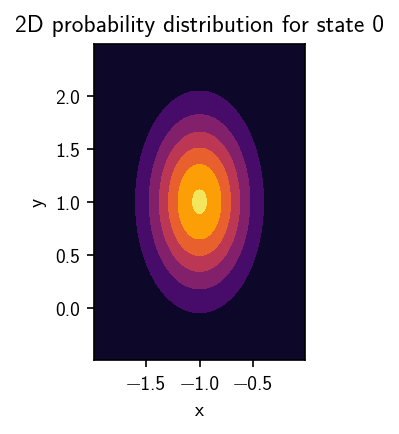

In [49]:
x, y = np.mgrid[-1.99:0:.01, -0.49:2.5:.01]
pos = np.dstack((x, y))

fig, ax = plt.subplots()
ax.contourf(
    x, y, system.state_distr_map[0].pdf(pos),
    cmap=mpl.cm.inferno
)
ax.set(**{
    "aspect": "equal",
    "title": "2D probability distribution for state 0",
    "xlabel": "x",
    "ylabel": "y",
})
fig.tight_layout()

### Continuous trajectory through feature space

Now we can translate the discrete trajectory through state space into a (randomised) continuous trajectory in feature space.

In [50]:
def sample_trajectory_from_discrete(dtraj, mapping):
    """Map discrete state trajectory to random conformational samples"""
    return np.array([
        mapping[state].rvs()
        for state in dtraj
    ])

In [51]:
system.traj = sample_trajectory_from_discrete(
    system.dtraj,
    system.state_distr_map
)

In [52]:
def get_transition_points(dtraj):
    """Determine state transition points in discrete trajectory"""
    inter_state_transitions = []

    for i, state in enumerate(dtraj[1:]):
        last_state = dtraj[i]

        if state != dtraj[i]:
            inter_state_transitions.append(i)
            
    return inter_state_transitions

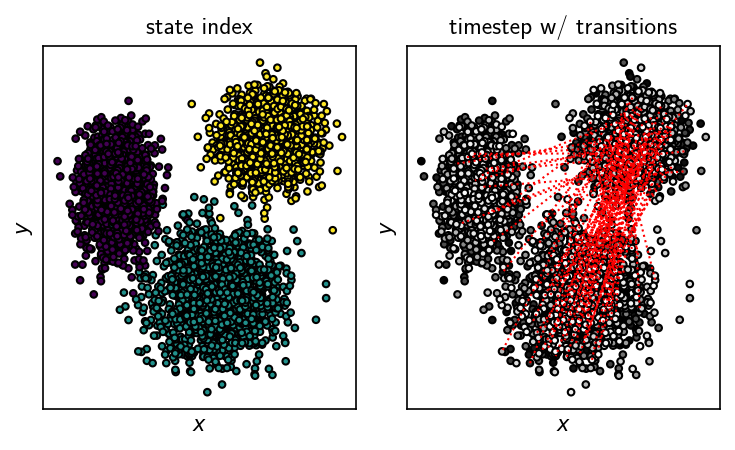

In [53]:
fig, (state_ax, time_ax) = plt.subplots(1, 2)
state_ax.scatter(
    *system.traj.T,
    c=system.dtraj,
    s=10,
    edgecolors="k", linewidths=1
)
time_ax.scatter(
    *system.traj.T,
    c=np.arange(system.traj.shape[0]),
    s=10,
    edgecolors="k", linewidths=1,
    cmap=mpl.cm.gray
)

for i in get_transition_points(system.dtraj):
    if i % 5 != 0:
        continue
    start = system.traj[i]
    end = system.traj[i + 1]
    time_ax.plot(
        [start[0], end[0]], [start[1], end[1]],
        color="red", linestyle="dotted", linewidth=1,
    )

for ax in (state_ax, time_ax):
    ax.set(**{
        "aspect": "equal",
        "xticks": (),
        "yticks": (),
        "xlabel": "$x$",
        "ylabel": "$y$"
    })
    
state_ax.set_title("state index")
time_ax.set_title("timestep w/ transitions")

fig.tight_layout()

### Exercise

Use the described scheme to generate your own toy data set, starting from a self-defined transition probability matrix (e.g. four states in 3D).

In [82]:
system_a = System("Another example")
system = system_a

In [83]:
system.transition_p_matrix = np.array([
    [0.97, 0.01, 0.01, 0.01],
    [0.01, 0.89, 0.06, 0.04],
    [0.01, 0.06, 0.60, 0.33],
    [0.01, 0.04, 0.33, 0.62],
])

assert np.all(np.sum(system.transition_p_matrix, axis=1) == 1)

# Dummy MSM from transition probabilities
sampled_msm = pyemma.msm.SampledMSM(system.transition_p_matrix)
system.dtraj = sampled_msm.simulate(5000)

# Four states in 3D
state_centers = np.array([
    [-1,  1,  1],
    [ 1, -1, -1],
    [ 2,  2,  2],
    [ 0,  0,  0],
])
state_covs = np.array([
    [[0.1, 0.0, 0.0],
     [0.0, 0.3, 0.0],
     [0.0, 0.0, 0.2]],
    [[0.4, 0.0, 0.0],
     [0.0, 0.4, 0.0],
     [0.0, 0.0, 0.4]],    
    [[0.2, 0.1, 0.1],
     [0.1, 0.2, 0.0],
     [0.1, 0.0, 0.2]],
    [[0.3, 0.0, 0.0],
     [0.0, 0.2, 0.1],
     [0.0, 0.1, 0.1]],
])

system.state_distr_map = make_state_distributions(state_centers, state_covs)

system.traj = sample_trajectory_from_discrete(
    system.dtraj,
    system.state_distr_map
)

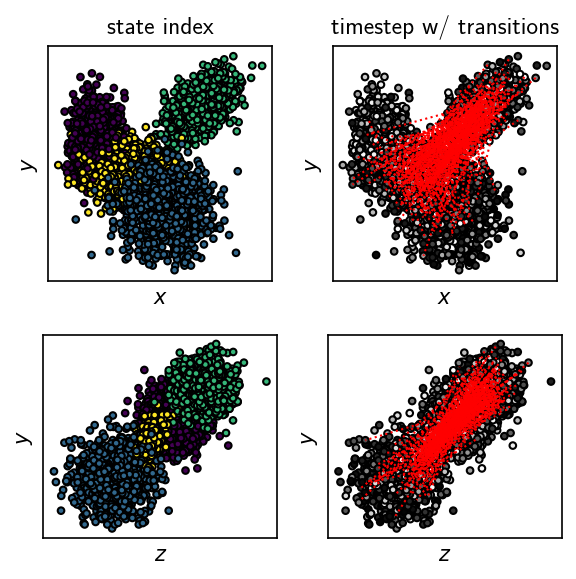

In [86]:
fig, Ax = plt.subplots(
    2, 2,
    figsize=(4, 4)
)
state_ax_a, time_ax_a, state_ax_b, time_ax_b = Ax.flatten()

order_a = np.argsort(system.traj[:, 2])[::-1]
state_ax_a.scatter(
    system.traj[:, 0][order_a],
    system.traj[:, 1][order_a],
    c=system.dtraj[order_a],
    s=10,
    edgecolors="k", linewidths=1,
    
)
order_b = np.argsort(system.traj[:, 0])
state_ax_b.scatter(
    system.traj[:, 2][order_b],
    system.traj[:, 1][order_b],
    c=system.dtraj[order_b],
    s=10,
    edgecolors="k", linewidths=1
)

time_ax_a.scatter(
    system.traj[:, 0][order_a],
    system.traj[:, 1][order_a],
    c=np.arange(system.traj.shape[0])[order_a],
    s=10,
    edgecolors="k", linewidths=1,
    cmap=mpl.cm.gray
)
time_ax_b.scatter(
    system.traj[:, 2][order_b],
    system.traj[:, 1][order_b],
    c=np.arange(system.traj.shape[0])[order_b],
    s=10,
    edgecolors="k", linewidths=1,
    cmap=mpl.cm.gray
)

for i in get_transition_points(system.dtraj):
    if i % 5 != 0:
        continue
    start = system.traj[i]
    end = system.traj[i + 1]
    time_ax_a.plot(
        [start[0], end[0]], [start[1], end[1]],
        color="red", linestyle="dotted", linewidth=1,
    )
    time_ax_b.plot(
        [start[2], end[2]], [start[1], end[1]],
        color="red", linestyle="dotted", linewidth=1,
    )

for ax in (state_ax_a, time_ax_a):
    ax.set(**{
        "aspect": "equal",
        "xticks": (),
        "yticks": (),
        "xlabel": "$x$",
        "ylabel": "$y$"
    })
    
for ax in (state_ax_b, time_ax_b):
    ax.set(**{
        "aspect": "equal",
        "xticks": (),
        "yticks": (),
        "xlabel": "$z$",
        "ylabel": "$y$"
    })
    
state_ax_a.set_title("state index")
time_ax_a.set_title("timestep w/ transitions")

fig.tight_layout()

## Principle component analysis

We want to use PCA to transform the input coordinates into a new set of *meaningful* coordinates. After PCA, the first obtained coordinate ($PC_1$) is aligned with the axis of maximum variance in the input space.

In [88]:
system = system_intro

In [89]:
# Do PCA
system.pca = decomposition.PCA(n_components=2)
system.pca.fit(system.traj)

PCA(n_components=2)

In [91]:
# Obtained principle components (n_component, n_dim)
components = system.pca.components_
components

array([[ 0.72503483,  0.6887122 ],
       [ 0.6887122 , -0.72503483]])

In [92]:
# Project original trajectory into PC-space
projected_trajectory = system.pca.transform(system.traj)

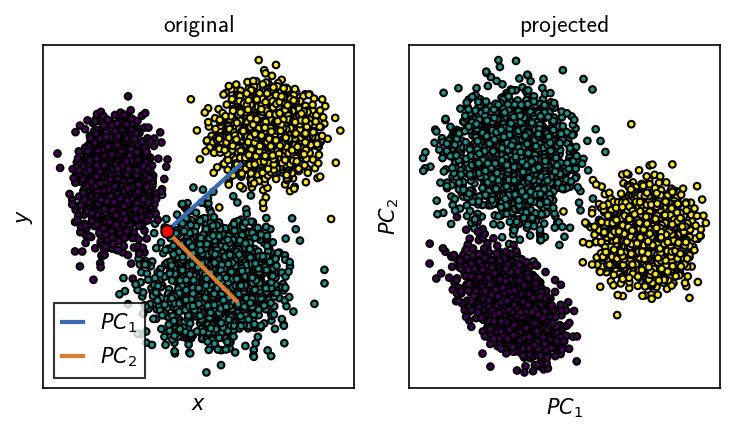

In [98]:
fig, (o_ax, p_ax) = plt.subplots(1, 2)
o_ax.scatter(
    *system.traj.T,
    c=system.dtraj,
    s=10,
    edgecolors="k", linewidths=1
)

scale = 2  # Scale PC vectors by this factor
o_ax.plot([0, components[0, 0] * scale], [0, components[0, 1] * scale], linewidth=2)
o_ax.plot([0, components[1, 0] * scale], [0, components[1, 1] * scale], linewidth=2)
o_ax.plot([0], [0], markerfacecolor="red", marker="o", markeredgecolor="k")

p_ax.scatter(
    *projected_trajectory.T,
    c=system.dtraj,
    s=10,
    edgecolors="k", linewidths=1
)
o_ax.set(**{
    "xticks": (),
    "yticks": (),
    "xlabel": "$x$",
    "ylabel": "$y$",
    "title": "original"
})

p_ax.set(**{
    "xticks": (),
    "yticks": (),
    "xlabel": "$PC_1$",
    "ylabel": "$PC_2$",
    "title": "projected"
})

o_ax.legend(
    ["$PC_1$", "$PC_2$"],
    handlelength=1,
    fancybox=False,
    edgecolor="k"
)

fig.tight_layout()

In [99]:
# How much information is entailed in the PCs?
system.pca.explained_variance_ratio_

array([0.55131006, 0.44868994])

### Exercise

Use `sklearn.decomposition.PCA` to perform a principle component analysis on your own data set.

In [100]:
system = system_a

In [102]:
system.pca = decomposition.PCA(n_components=3)
system.pca.fit(system.traj)

PCA(n_components=3)

In [103]:
system.pca.explained_variance_ratio_

array([0.59893061, 0.34749873, 0.05357066])

In [104]:
system.pca = decomposition.PCA(n_components=2)
system.pca.fit(system.traj)

PCA(n_components=2)

In [107]:
components = system.pca.components_

In [105]:
projected_trajectory = system.pca.transform(system.traj)

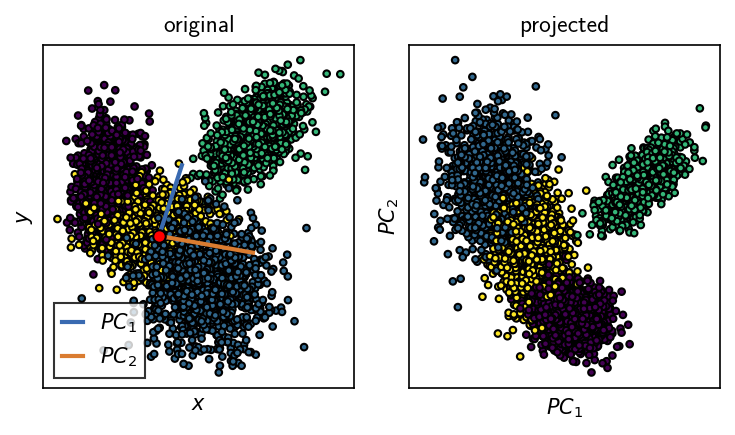

In [108]:
fig, (o_ax, p_ax) = plt.subplots(1, 2)

order_o = np.argsort(system.traj[:, 2])[::-1]
o_ax.scatter(
    system.traj[:, 0][order_o],
    system.traj[:, 1][order_o],
    c=system.dtraj[order_o],
    s=10,
    edgecolors="k", linewidths=1
)

scale = 2  # Scale PC vectors by this factor
o_ax.plot([0, components[0, 0] * scale], [0, components[0, 1] * scale], linewidth=2)
o_ax.plot([0, components[1, 0] * scale], [0, components[1, 1] * scale], linewidth=2)
o_ax.plot([0], [0], markerfacecolor="red", marker="o", markeredgecolor="k")


p_ax.scatter(
    *projected_trajectory.T,
    c=system.dtraj,
    s=10,
    edgecolors="k", linewidths=1
)
o_ax.set(**{
    "xticks": (),
    "yticks": (),
    "xlabel": "$x$",
    "ylabel": "$y$",
    "title": "original"
})

p_ax.set(**{
    "xticks": (),
    "yticks": (),
    "xlabel": "$PC_1$",
    "ylabel": "$PC_2$",
    "title": "projected"
})

o_ax.legend(
    ["$PC_1$", "$PC_2$"],
    handlelength=1,
    fancybox=False,
    edgecolor="k"
)

fig.tight_layout()

## Correlation

### Exercise

Use `numpy.corrcoef` to calculate the the Pearson correlation coefficient between the two original coordinates and the between the obtained principle components. What do  you observe?

In [23]:
corrcoeff = np.corrcoef(trajectory[:, 0], trajectory[:, 1])[0, 1]
corrcoeff_projected = np.corrcoef(projected_trajectory[:, 0], projected_trajectory[:, 1])[0, 1]
print(f"Correlation (original):  {corrcoeff}")
print(f"Correlation (projected): {corrcoeff_projected}")

NameError: name 'trajectory' is not defined

## Time-lagged independent component analysis

In [111]:
system = system_intro

In [112]:
system.tica = pyemma.coordinates.tica(system.traj, var_cutoff=1)

In [113]:
tica_components = system.tica.eigenvectors.T
tica_components

array([[ 0.44870114, -0.19643375],
       [ 0.00967275,  0.0279646 ]])

In [114]:
system.tica.describe()

'[TICA, lag = 10; max. output dim. = 2]'

In [115]:
system.tica.cumvar

array([0.99585122, 1.        ])

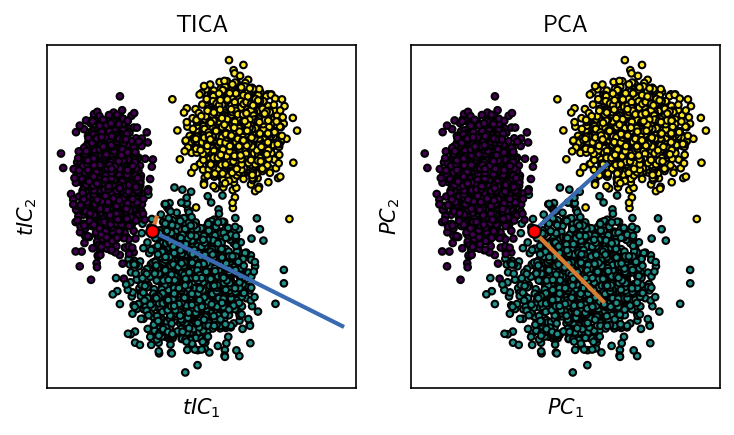

In [116]:
fig, (tica_ax, pca_ax) = plt.subplots(1, 2)
tica_ax.scatter(
    *system.traj.T,
    c=system.dtraj,
    s=10,
    edgecolors="k", linewidths=1
)

scale = 10
tica_ax.plot([0, tica_components[0, 0] * scale], [0, tica_components[0, 1] * scale], linewidth=2)
tica_ax.plot([0, tica_components[1, 0] * scale], [0, tica_components[1, 1] * scale], linewidth=2)
tica_ax.plot([0], [0], markerfacecolor="red", marker="o", markeredgecolor="k")

pca_ax.scatter(
    *system.traj.T,
    c=system.dtraj,
    s=10,
    edgecolors="k", linewidths=1
)

scale = 2
pca_ax.plot([0, system.pca.components_[0, 0] * scale], [0, system.pca.components_[0, 1] * scale], linewidth=2)
pca_ax.plot([0, system.pca.components_[1, 0] * scale], [0, system.pca.components_[1, 1] * scale], linewidth=2)
pca_ax.plot([0], [0], markerfacecolor="red", marker="o", markeredgecolor="k")

tica_ax.set(**{
    "xticks": (),
    "yticks": (),
    "xlabel": "$tIC_1$",
    "ylabel": "$tIC_2$",
    "title": "TICA"
})

pca_ax.set(**{
    "xticks": (),
    "yticks": (),
    "xlabel": "$PC_1$",
    "ylabel": "$PC_2$",
    "title": "PCA"
})

fig.tight_layout()

### Exercise

Use `pyemma.coordinates.tica` to perform a time-lagged independent component analysis on your own data set.

In [118]:
system = system_a

In [129]:
system.tica = pyemma.coordinates.tica(system.traj, var_cutoff=0.999)

In [130]:
system.tica.describe()

'[TICA, lag = 10; max. output dim. = 2]'

In [131]:
system.tica.cumvar

array([0.99074053, 0.99996688, 1.        ])

In [132]:
components = system.tica.eigenvectors.T

In [133]:
projected_trajectory = np.concatenate(system.tica.get_output())

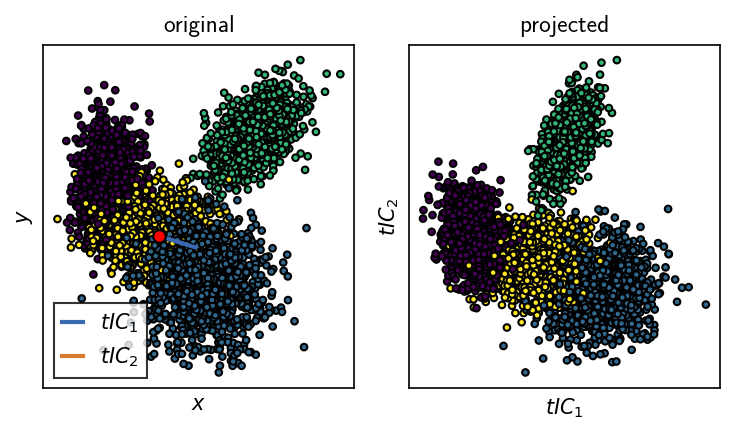

In [135]:
fig, (o_ax, p_ax) = plt.subplots(1, 2)

order_o = np.argsort(system.traj[:, 2])[::-1]
o_ax.scatter(
    system.traj[:, 0][order_o],
    system.traj[:, 1][order_o],
    c=system.dtraj[order_o],
    s=10,
    edgecolors="k", linewidths=1
)

scale = 2  # Scale PC vectors by this factor
o_ax.plot([0, components[0, 0] * scale], [0, components[0, 1] * scale], linewidth=2)
o_ax.plot([0, components[1, 0] * scale], [0, components[1, 1] * scale], linewidth=2)
o_ax.plot([0], [0], markerfacecolor="red", marker="o", markeredgecolor="k")


p_ax.scatter(
    *projected_trajectory.T,
    c=system.dtraj,
    s=10,
    edgecolors="k", linewidths=1
)
o_ax.set(**{
    "xticks": (),
    "yticks": (),
    "xlabel": "$x$",
    "ylabel": "$y$",
    "title": "original"
})

p_ax.set(**{
    "xticks": (),
    "yticks": (),
    "xlabel": "$tIC_1$",
    "ylabel": "$tIC_2$",
    "title": "projected"
})

o_ax.legend(
    ["$tIC_1$", "$tIC_2$"],
    handlelength=1,
    fancybox=False,
    edgecolor="k"
)

fig.tight_layout()

## Clustering to generate discrete trajectories

In [32]:
clustering = cluster.Clustering(np.concatenate(system.tica.get_output()))

In [33]:
clustering.fit(0.05, 50, member_cutoff=10)

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
5000      0.050     50        10        None      3         0.342     0.107     00:00:1.214
-----------------------------------------------------------------------------------------------



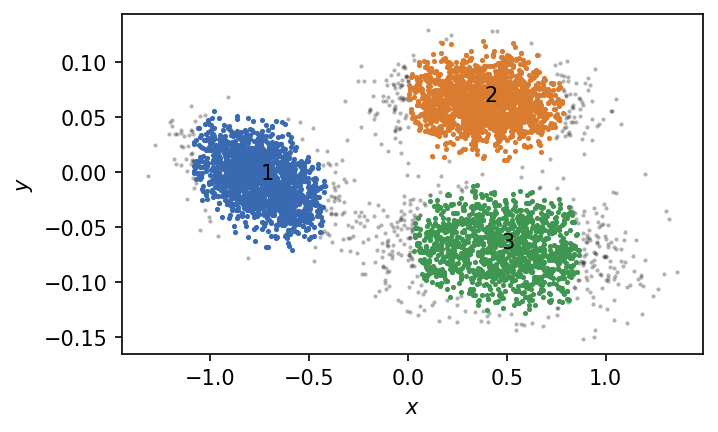

In [34]:
_ = clustering.evaluate()

## MSM estimation

In [44]:
dtrajs = [a - 1 for a in clustering.to_dtrajs()]

In [45]:
dtrajs

[array([2, 2, 2, ..., 1, 1, 1])]

In [46]:
its = pyemma.msm.its(dtrajs, lags=[1, 2, 3, 5, 7, 10], nits=3)

estimating MaximumLikelihoodMSM:   0%|                  | 0/6 [00:00<?, ?it/s]

25-10-21 18:09:52 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[5] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
25-10-21 18:09:52 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[5] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
25-10-21 18:09:52 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[5] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
25-10-21 18:09:52 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[5] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.


estimating MaximumLikelihoodMSM:  17%|█▋        | 1/6 [00:00<00:00,  7.71it/s]

25-10-21 18:09:52 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[6] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
25-10-21 18:09:52 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[6] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 36.70it/s]


25-10-21 18:09:52 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[3] WARNING  Changed user setting nits to the number of available timescales nits=2


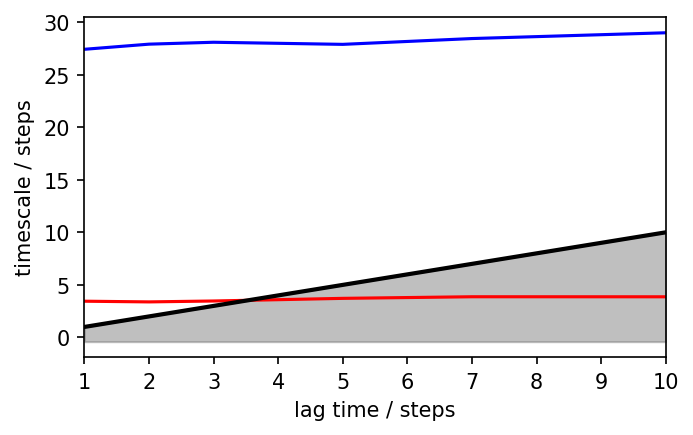

In [47]:
pyemma.plots.plot_implied_timescales(its, ylog=False)

In [48]:
MSM = pyemma.msm.estimate_markov_model(dtrajs, lag=2)

25-10-21 18:10:02 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[5] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.


In [50]:
MSM.P

array([[0.95426996, 0.04215855, 0.00357149],
       [0.0432103 , 0.7700565 , 0.1867332 ],
       [0.0046127 , 0.23530237, 0.76008493]])

## Scratch

In [109]:
def multivar_gaussian_pdf(x, cov, mu):
    """Multivariate gaussian PDF"""
    
    n = x.shape[0]
    
    assert n == mu.shape[0] == cov.shape[0] == cov.shape[1], f"! {n} == {mu.shape[0]} == {cov.shape[0]} == {cov.shape[1]}"
    
    det = np.linalg.det(cov)
    inv = np.linalg.inv(cov)
    
    delta_xm = x - mu
    
    return 1 / ((2 * np.pi)**(n/2) * np.sqrt(det)) * np.exp(-0.5 * (delta_xm.T @ inv @ delta_xm))